<a href="https://colab.research.google.com/github/Omar-Zantot/student-score-prediction/blob/main/student_score_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 Step 1: Data Analysis & Preprocessing

In [16]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math

#!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## ✅ Step 1.1: Load the Dataset

In [4]:
# Fetch the Student Performance dataset (ID 320 on UCI)
student_data = fetch_ucirepo(id=320)
df = student_data.data.original

# Preview the data
print("Shape:", df.shape)
df.head()


Shape: (649, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


## ✅ Step 1.2: Understand the Dataset Structure

In [5]:
# Basic structure info
df.info()

# Count numerical and categorical columns
num_cols = df.select_dtypes(include='number').columns
cat_cols = df.select_dtypes(include='object').columns

print("📊 Number of numerical features:", len(num_cols))
print("🔤 Number of categorical features:", len(cat_cols))
print("\nCategorical columns:", list(cat_cols))

# Check for missing values
print("\n❓ Missing values in dataset:")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

📝 **Dataset Structure Summary**

- The dataset contains **649 rows** and **33 columns**.
- There are **16 numerical features** and **17 categorical features**.
- ✅ No missing values were found in any column.


---

🔍 **Insights**:
- Categorical columns (like `school`, `sex`, `Mjob`, etc.) need to be **encoded** before modeling.
- Numerical columns may need **scaling**, especially for certain models (e.g., KNN, SVR, Neural Network).



## ✅ Step 1.3: Explore Distributions

In [6]:
def plot_hist_kde_grid(df, columns, cols_per_row=4):
    total = len(columns)
    rows = math.ceil(total / cols_per_row)
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row * 4, rows * 3))

    for i, col in enumerate(columns):
        r, c = divmod(i, cols_per_row)
        ax = axes[r][c] if rows > 1 else axes[c]
        sns.histplot(df[col], kde=True, bins=20, ax=ax)
        ax.set_title(f'Distribution of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')

    # Hide unused plots
    for j in range(i+1, rows * cols_per_row):
        r, c = divmod(j, cols_per_row)
        ax = axes[r][c] if rows > 1 else axes[c]
        ax.axis('off')

    plt.tight_layout()
    plt.show()


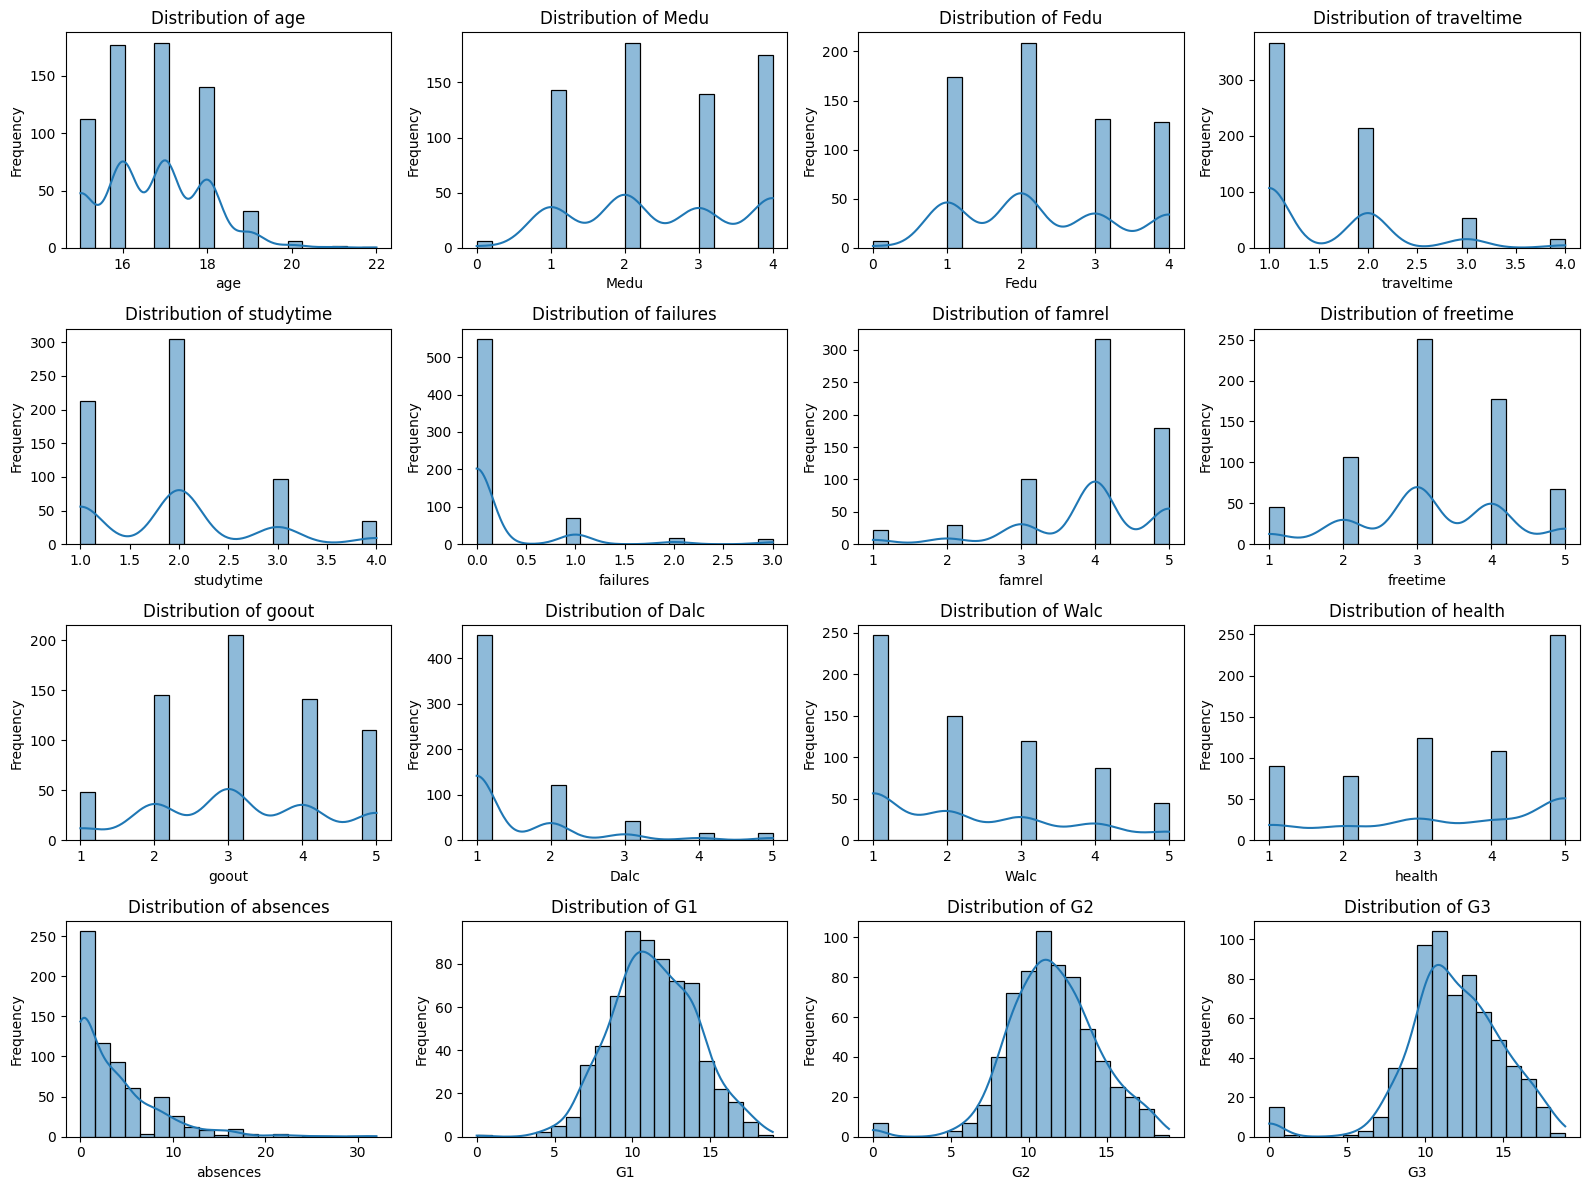

In [7]:
plot_hist_kde_grid(df, num_cols)

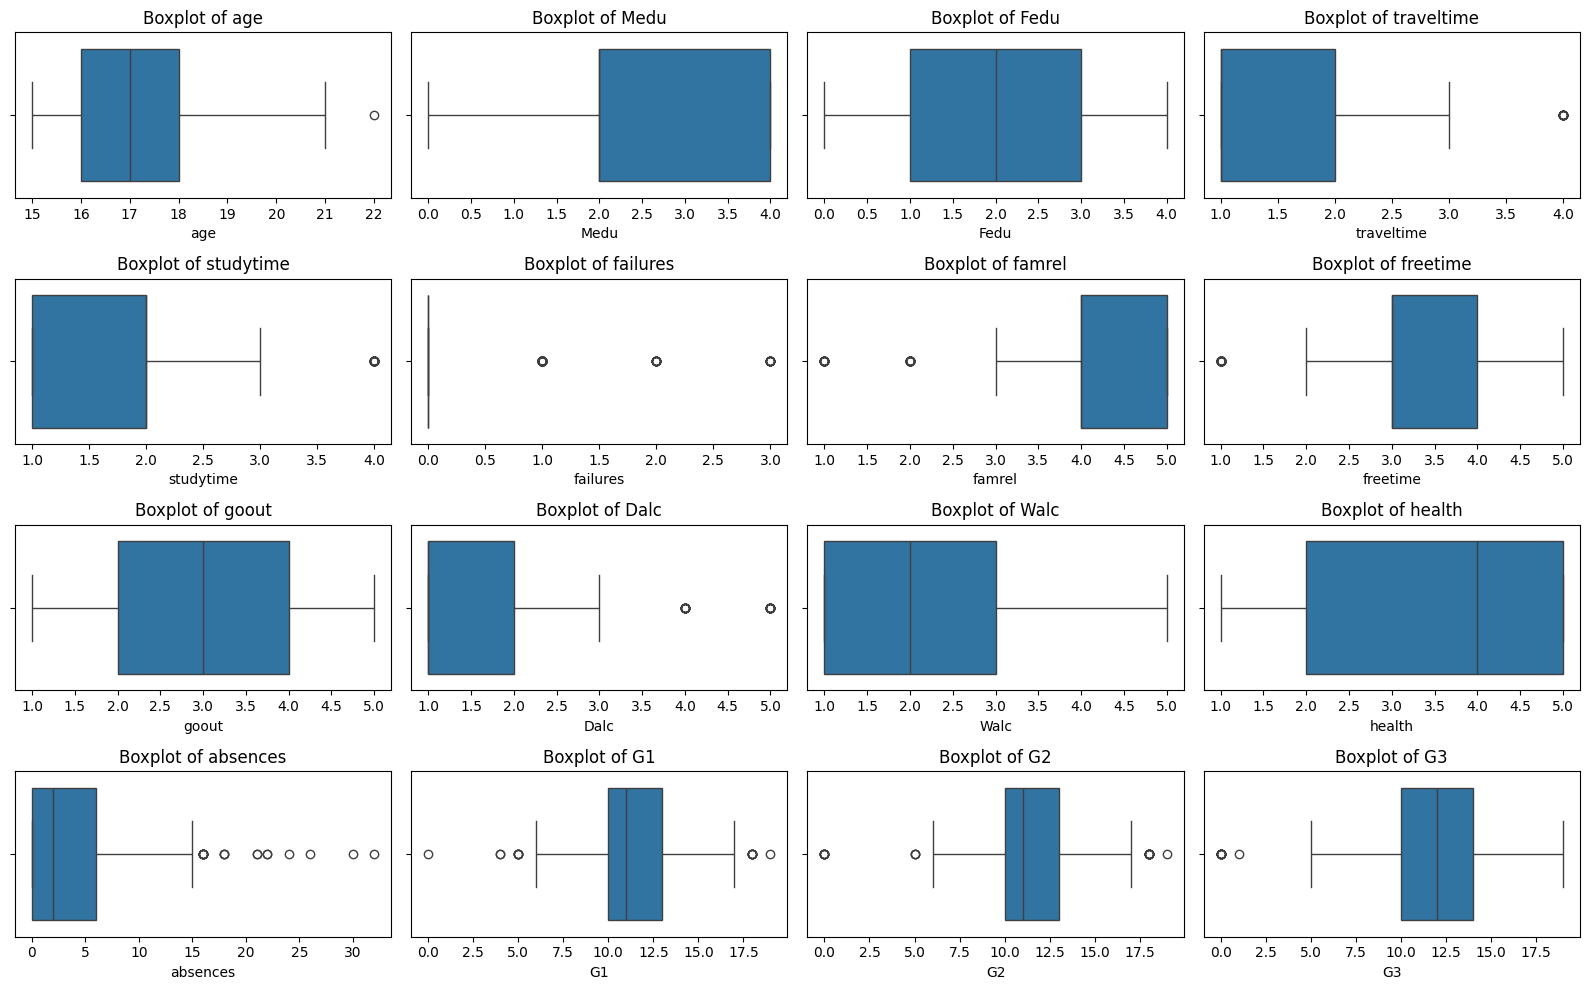

In [8]:
def plot_boxplot_grid(df, columns, cols_per_row=4):
    total = len(columns)
    rows = math.ceil(total / cols_per_row)
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row * 4, rows * 2.5))

    for i, col in enumerate(columns):
        r, c = divmod(i, cols_per_row)
        ax = axes[r][c] if rows > 1 else axes[c]
        sns.boxplot(x=df[col], ax=ax)
        ax.set_title(f'Boxplot of {col}')
        ax.set_xlabel(col)

    # Hide unused subplots
    for j in range(i + 1, rows * cols_per_row):
        r, c = divmod(j, cols_per_row)
        ax = axes[r][c] if rows > 1 else axes[c]
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_boxplot_grid(df, num_cols)

🔍 Key Observations:

| Feature       | Distribution Insights                             | Outlier Observations                    |
|---------------|----------------------------------------------------|-----------------------------------------|
| **age**       | Clustered between 15–18 (expected school age)     | One possible outlier at age 22          |
| **Medu/Fedu** | Discrete levels (0–4), skewed toward higher values| No significant outliers                 |
| **traveltime**| Right-skewed, most values at 1–2                  | Minor outliers at 4                     |
| **studytime** | Right-skewed, majority at 2                       | Outlier at 4                            |
| **failures**  | Highly skewed, most students = 0                  | Strong outliers at 2 and 3              |
| **famrel**    | Acceptable spread, centered around 4–5            | Mild low outlier at 1                   |
| **freetime**  | Moderate spread, slight skew                      | Minor low outlier                       |
| **goout**     | Balanced across 1–5                               | No major outliers                       |
| **Dalc/Walc** | Strong right skew (most = 1)                      | Clear outliers at 4 and 5               |
| **health**    | Fairly flat distribution                          | No outliers                             |
| **absences**  | Strong right skew, long tail                     | Many strong outliers (10–30+)           |
| **G1/G2/G3**  | Near-normal bell shape, ideal for regression      | Mild outliers at both ends              |

---

📌 No transformations were applied yet.
We will decide later whether to:
- Cap or transform outliers (e.g., `absences`, `failures`)
- Binarize strongly skewed features (e.g., `Dalc`, `Walc`)

Next step: Encoding categorical features → Step 1.4


In [9]:
df_cleaned = df.copy()

# ✅ 1. Cap outliers in 'absences' and 'failures'
df_cleaned['absences_capped'] = df_cleaned['absences'].clip(upper=25)
df_cleaned['failures_capped'] = df_cleaned['failures'].clip(upper=2)

# ✅ 2. Binarize alcohol use
df_cleaned['Dalc_high'] = (df_cleaned['Dalc'] > 1).astype(int)
df_cleaned['Walc_high'] = (df_cleaned['Walc'] > 1).astype(int)

# ✅ 3. Drop or ignore original versions (optional for clarity)
# Keep original in case you want to experiment later
# df_cleaned.drop(['absences', 'failures', 'Dalc', 'Walc'], axis=1, inplace=True)

# 👀 Check the result
df_cleaned[['absences', 'absences_capped', 'failures', 'failures_capped', 'Dalc', 'Dalc_high', 'Walc', 'Walc_high']].head()


,absences,absences_capped,failures,failures_capped,Dalc,Dalc_high,Walc,Walc_high
0,4,4,0,0,1,0,1,0
1,2,2,0,0,1,0,1,0
2,6,6,0,0,2,1,3,1
3,0,0,0,0,1,0,1,0
4,0,0,0,0,1,0,2,1


## ✅ Step 1.4: Encoding Categorical Features

In [10]:
# Get all categorical columns
cat_cols = df_cleaned.select_dtypes(include='object').columns.tolist()
print("Categorical columns:", cat_cols)

# Define binary values we can map
binary_map = {
    'yes': 1, 'no': 0,
    'F': 0, 'M': 1,
    'U': 1, 'R': 0,
    'GT3': 1, 'LE3': 0,
    'T': 1, 'A': 0
}

# Split binary vs nominal categorical columns
binary_cols = [col for col in cat_cols if df_cleaned[col].nunique() == 2 and set(df_cleaned[col].unique()).issubset(binary_map.keys())]
nominal_cols = [col for col in cat_cols if col not in binary_cols]

# Apply label encoding for binary columns
df_encoded = df_cleaned.copy()
for col in binary_cols:
    df_encoded[col] = df_encoded[col].map(binary_map)

# Apply one-hot encoding for nominal columns
df_encoded = pd.get_dummies(df_encoded, columns=nominal_cols, drop_first=True)

print("✅ Binary encoded columns:", binary_cols)
print("✅ One-hot encoded columns:", nominal_cols)


Categorical columns: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
✅ Binary encoded columns: ['sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
✅ One-hot encoded columns: ['school', 'Mjob', 'Fjob', 'reason', 'guardian']


In [11]:
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print("New shape after encoding:", df_encoded.shape)
df_encoded.head()

New shape after encoding: (649, 42)


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,True,False,True,False,False,False,True,True,False,False
1,17,1,1,1,2,0,5,3,3,1,...,False,False,False,True,False,False,False,True,True,False
2,15,1,1,1,2,0,4,3,2,2,...,True,False,True,False,False,False,True,True,True,False
3,15,4,2,1,3,0,3,2,2,1,...,True,False,False,True,False,True,True,True,True,True
4,16,3,3,1,2,0,4,3,2,1,...,False,False,False,True,False,False,True,True,False,False


## ✅ Step 1.5: Feature Scaling & Spliting

In [14]:
from sklearn.preprocessing import StandardScaler

# Step 1: Separate target
target = 'G3'
X = df_encoded.drop(columns=target)
y = df_encoded[target]

# Step 2: Identify numerical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Checks for binary columns (like 0/1) — no need to scale them.
binary_like_cols = [col for col in numerical_cols if X[col].nunique() <= 2]
numerical_cols = [col for col in numerical_cols if col not in binary_like_cols]

# Step 3: Scale numerical features
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Step 4: 	Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print("🎉 Scaling done! Shapes:")
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)


🎉 Scaling done! Shapes:
X_train: (519, 41)
X_test : (130, 41)


# 📘 Step 2: Model Training

In this phase, we will train and evaluate a series of regression models to predict students' final exam scores (`G3`) based on the preprocessed features.

---

## 🧠 Part 1: Classical Machine Learning Models

We will train the following models:

1. **Linear Regression**
2. **Decision Tree Regressor**
3. **Random Forest Regressor**
4. **K-Nearest Neighbors (KNN) Regressor**
5. **Support Vector Regressor (SVR)**

### 📏 Evaluation Metrics
Each model will be evaluated using the following metrics:

- **MAE** (Mean Absolute Error)
- **RMSE** (Root Mean Squared Error)
- **R² Score** (Explained Variance)

A utility function will be used to compute and return these metrics for each model.

---

## 🤖 Part 2: Neural Network (TensorFlow / Keras)

We will build and train a feedforward neural network for regression with the following architecture:

- **Input Layer**: Number of features
- **Hidden Layers**:
  - Dense(64) + ReLU
  - Dense(32) + ReLU
- **Output Layer**: Dense(1), Linear activation

### 🧪 Training Details:
- **Loss Function**: Mean Squared Error (MSE)
- **Optimizer**: Adam
- **Metrics**: Mean Absolute Error (MAE)
- **Epochs**: ~100
- **Batch Size**: 32

We’ll also visualize:
- Training loss over epochs
- Actual vs. Predicted scores on the test set

---


## ✅ Classical Model Training





In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

def evaluate_model(model, X_test, y_test):
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    import numpy as np
    y_pred = model.predict(X_test)
    return {
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R²": r2_score(y_test, y_pred)
    }


# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "KNN": KNeighborsRegressor(),
    "SVR": SVR()
}

# Train, predict, evaluate
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    results[name] = evaluate_model(model, X_test, y_test)

# Display results
print("📊 Model Performance Summary:")
for name, scores in results.items():
    print(f"\n{name}")
    for metric, value in scores.items():
        print(f"{metric}: {value:.4f}")


📊 Model Performance Summary:

Linear Regression
MAE: 0.7651
RMSE: 1.2149
R²: 0.8487

Decision Tree
MAE: 0.9231
RMSE: 1.6502
R²: 0.7208

Random Forest
MAE: 0.7486
RMSE: 1.2432
R²: 0.8415

KNN
MAE: 1.1846
RMSE: 1.6314
R²: 0.7271

SVR
MAE: 0.9052
RMSE: 1.5115
R²: 0.7657


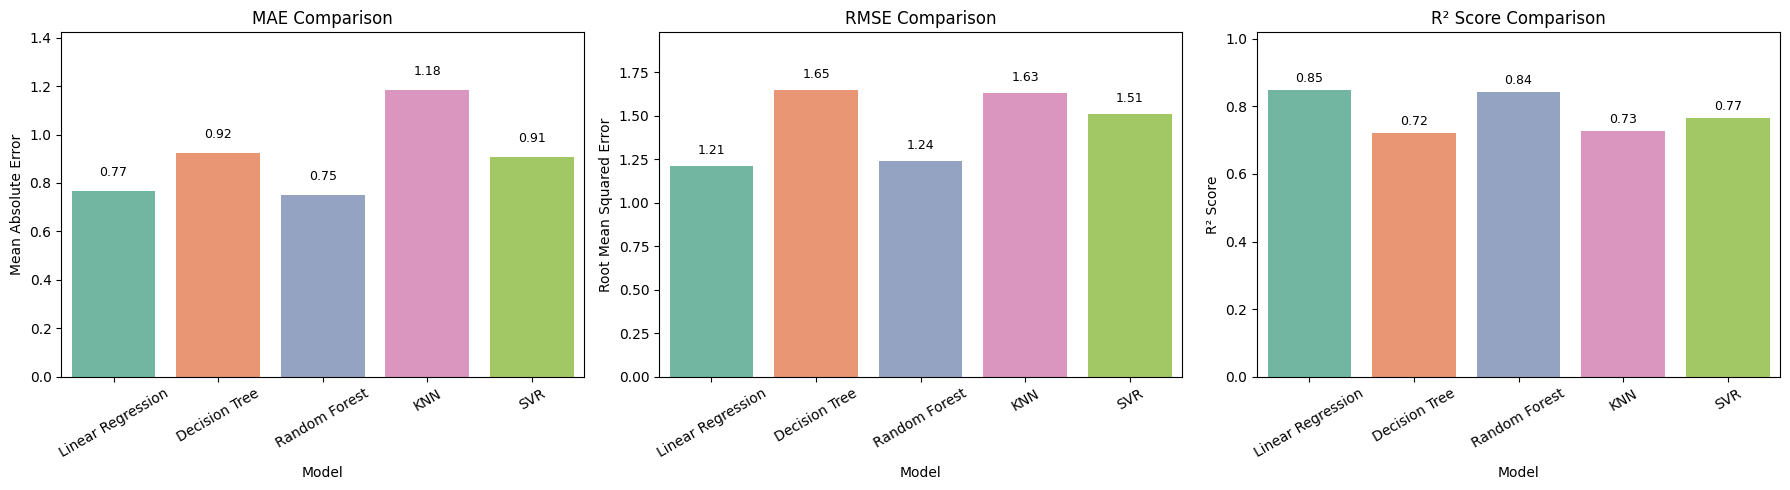

## 📊 Model Performance Summary & Interpretation

After evaluating five classical machine learning models, here’s a breakdown of their results and **why** each performed the way it did:

### 🔎 Model Metrics

| Model              | MAE   | RMSE  | R²     |
|-------------------|-------|-------|--------|
| Linear Regression | 0.76  | 1.21  | 0.85   |
| Random Forest     | 0.75  | 1.24  | 0.84   |
| SVR               | 0.91  | 1.51  | 0.76   |
| Decision Tree     | 0.92  | 1.65  | 0.72   |
| KNN               | 1.18  | 1.63  | 0.73   |

### ✅ Key Takeaways

- **Linear Regression** performed best, likely because:
  - The target (`G3`) has a strong **linear relationship** with prior grades (`G1`, `G2`).
  - The model is simple and generalizes well with clean data.

- **Random Forest** came close and is very stable:
  - Captures non-linear patterns.
  - Handles high-dimensional encoded features and outliers better.

- **SVR** lagged behind:
  - Very sensitive to **scaling** and **requires tuning** (kernel, C, epsilon).
  - Struggles with too many features unless optimized.

- **Decision Tree** overfit the training data:
  - High variance without pruning.
  - Does not generalize well to new samples.

- **KNN** performed worst:
  - Suffers from the **curse of dimensionality**.
  - Highly sensitive to feature scaling and irrelevant features.

### 🧠 Why Models Performed Differently

| Factor                   | Linear | RF   | SVR  | Tree | KNN  |
|--------------------------|--------|------|------|------|------|
| Captures linear patterns | ✅     | ✅   | ✅   | ❌   | ❌   |
| Handles outliers         | ❌     | ✅   | ⚠️   | ✅   | ❌   |
| Sensitive to scaling     | ⚠️     | ❌   | ✅   | ❌   | ✅   |
| Needs tuning             | ⚠️     | ✅   | ✅  | ✅   | ✅   |
| Handles many features    | ⚠️     | ✅   | ⚠️   | ⚠️   | ❌   |

---

### 🧭 Next Step:
Move on to **Neural Network** implementation to test if a more flexible non-linear model can outperform the classical ones.


## ✅ Neural Network (NN) using TensorFlow/Keras.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 146.7384 - mae: 11.6301 - val_loss: 169.1073 - val_mae: 12.8558
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 141.2288 - mae: 11.5467 - val_loss: 158.6565 - val_mae: 12.4640
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 143.7359 - mae: 11.7206 - val_loss: 149.2184 - val_mae: 12.0980
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 133.3952 - mae: 11.3000 - val_loss: 141.3230 - val_mae: 11.7835
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 131.6163 - mae: 11.2013 - val_loss: 133.3106 - val_mae: 11.4507
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 123.9150 - mae: 10.9089 - val_loss: 125.8163 - val_mae: 11.1299
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 126.1403 - mae: 10.9922 - val_loss: 117.9766 - val_mae: 10.7822
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 123.4776 - mae: 10.8945 - val_loss: 111.5463 - val_mae: 10.4871
Epoch 9/100


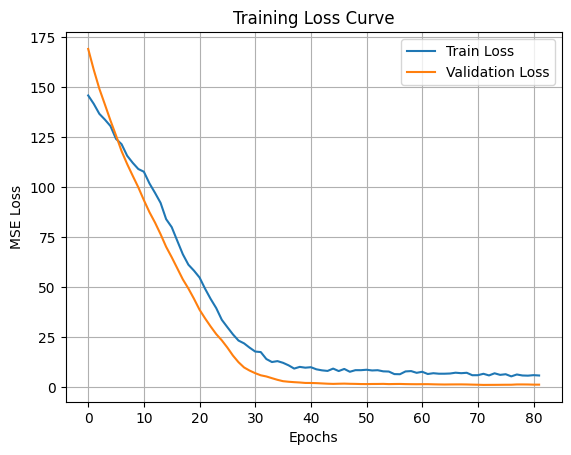

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# 🧠 Build model
model = Sequential([
    Dense(64, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='linear')
])
# 🛠 Compile
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# 🛑 Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 🏋️ Train
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# 🔍 Evaluate
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n📊 Final NN Performance:\nMAE: {mae:.4f}\nRMSE: {rmse:.4f}\nR²: {r2:.4f}")

# 📈 Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()


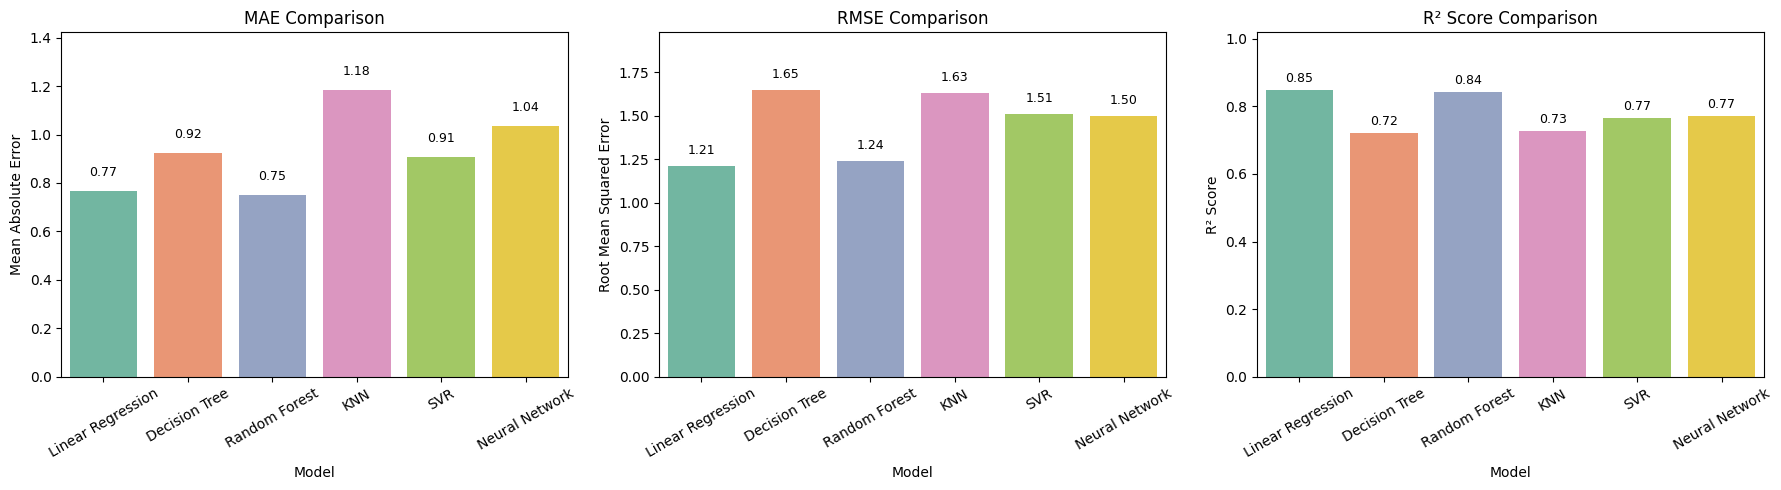

In [38]:
# Create a DataFrame
data = {
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest', 'KNN', 'SVR', 'Neural Network'],
    'MAE': [0.7651, 0.9231, 0.7486, 1.1846, 0.9052, 1.0358],
    'RMSE': [1.2149, 1.6502, 1.2432, 1.6314, 1.5115, 1.4985],
    'R2': [0.8487, 0.7208, 0.8415, 0.7271, 0.7657, 0.7697]
}
df_metrics = pd.DataFrame(data)

palette = sns.color_palette("Set2")[:6]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['MAE', 'RMSE', 'R2']
titles = ['MAE Comparison', 'RMSE Comparison', 'R² Score Comparison']
y_labels = ['Mean Absolute Error', 'Root Mean Squared Error', 'R² Score']

for i, metric in enumerate(metrics):
    sns.barplot(
        x='Model', y=metric, hue='Model', data=df_metrics,
        ax=axes[i], palette=palette, legend=False
    )
    axes[i].set_title(titles[i])
    axes[i].set_ylabel(y_labels[i])
    axes[i].tick_params(axis='x', rotation=30)

    for bar in axes[i].patches:
        height = bar.get_height()
        axes[i].text(
            bar.get_x() + bar.get_width() / 2,
            height + (0.05 if metric != 'R2' else 0.015),
            f'{height:.2f}',
            ha='center',
            va='bottom',
            fontsize=9
        )

    axes[i].set_ylim(0, max(df_metrics[metric]) * 1.2)

plt.tight_layout()
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


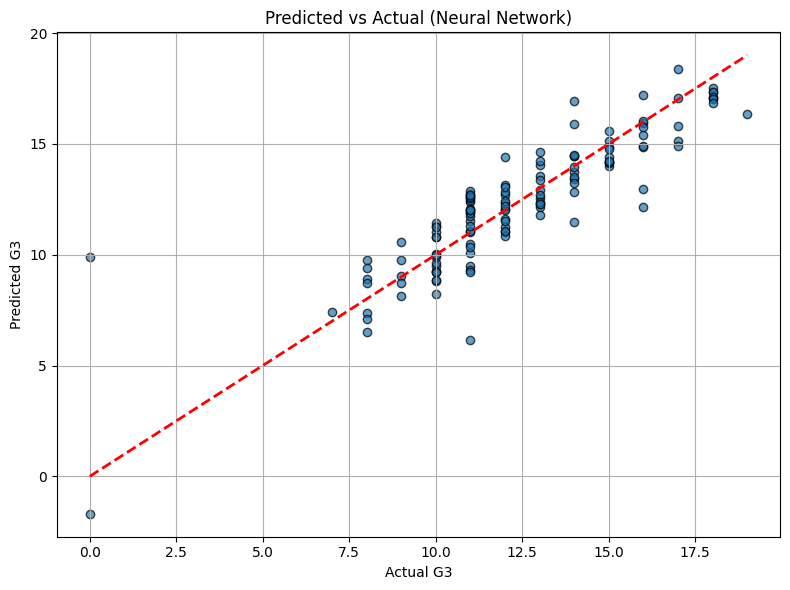

In [40]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Predict using the trained NN model
y_pred_nn = model.predict(X_test).flatten()

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_nn, alpha=0.7, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.title('Predicted vs Actual (Neural Network)')
plt.xlabel('Actual G3')
plt.ylabel('Predicted G3')
plt.grid(True)
plt.tight_layout()
plt.show()
